# 7장. 케라스2로 구현하는 GAN(생성적 경쟁 신경망)
## 7.2 확률분포 생성을 위한 완전 연결 계층 GAN 구현
필기체 숫자 즉 MNIST를 이용해 AE을 구현

In [1]:
# set to use CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

### 7.2.1 패키지 임포트 
- 확률분포 생성 GAN을 구현하는 데 필요한 패키지 임포트

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda

from keras.optimizers import Adam
from keras import backend as K

ModuleNotFoundError: No module named 'keras'

### 7.2.2 데이터 생성 클래스
- GAN에 적용할 데이터 관리 클래스

In [4]:
class Data:
    def __init__(self, mu, sigma, ni_D):
        self.real_sample = lambda n_batch: np.random.normal(mu, sigma, (n_batch, ni_D))
        self.in_sample = lambda n_batch: np.random.rand(n_batch, ni_D)

### 7.2.4 GAN 모델링
- GAN을 모델링

In [ ]:
def add_decorate(x):
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)
    return K.concatenate([x, d], axis=-1)

def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] *= 2
    return tuple(shape)

lr = 2e-4  # 0.0002
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999)
def model_compile(model):
    return model.compile(loss='binary_crossentropy', optimizer=adam,
                         metrics=['accuracy'])

class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G

        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()

    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D
        D = models.Sequential()
        D.add(Lambda(add_decorate, output_shape=add_decorate_shape,
                     input_shape=(ni_D,)))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))

        model_compile(D)
        return D

    def gen_G(self):
        ni_D = self.ni_D
        nh_G = self.nh_D

        G = models.Sequential()
        G.add(Reshape((ni_D, 1), input_shape=(ni_D,)))
        G.add(Conv1D(nh_G, 1, activation='relu'))
        G.add(Conv1D(nh_G, 1, activation='sigmoid'))
        G.add(Conv1D(1, 1))
        G.add(Flatten())

        model_compile(G)
        return G

    def make_GD(self):
        G, D = self.G, self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        model_compile(GD)
        D.trainable = True
        return GD

    def D_train_on_batch(self, Real, Gen):
        D = self.D
        X = np.concatenate([Real, Gen], axis=0)
        y = np.array([1] * Real.shape[0] + [0] * Gen.shape[0])
        D.train_on_batch(X, y)

    def GD_train_on_batch(self, Z):
        GD = self.GD
        y = np.array([1] * Z.shape[0])
        GD.train_on_batch(Z, y)

### 7.2.4 머신 구현하기
- 머신은 데이터와 모델로 GAN을 학습하고 성능을 평가하는 인공신경망 전체를 총괄하는 객체

In [ ]:
class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25

        self.n_iter_D = 1
        self.n_iter_G = 5

        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D=50, nh_G=50)

        self.n_batch = n_batch
        # self.ni_D = ni_D

    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data

        # Real data
        Real = data.real_sample(n_batch)  # (n_batch, ni_D)
        # Generated data
        Z = data.in_sample(n_batch)  # (n_batch, ni_D)
        Gen = gan.G.predict(Z)  # (n_batch, ni_D)

        gan.D.trainable = True
        gan.D_train_on_batch(Real, Gen)

    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        # Seed data for data generation
        Z = data.in_sample(n_batch)

        gan.D.trainable = False
        gan.GD_train_on_batch(Z)

    def train_each(self):
        for it in range(self.n_iter_D):
            self.train_D()
        for it in range(self.n_iter_G):
            self.train_GD()

    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each()

    def test(self, n_test):
        gan = self.gan
        data = self.data
        Z = data.in_sample(n_test)
        Gen = gan.G.predict(Z)
        return Gen, Z

    def show_hist(self, Real, Gen, Z):
        plt.hist(Real.reshape(-1), histtype='step', label='Real')
        plt.hist(Gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)

    def test_and_show(self, n_test):
        data = self.data
        Gen, Z = self.test(n_test)
        Real = data.real_sample(n_test)
        self.show_hist(Real, Gen, Z)
        Machine.print_stat(Real, Gen)

    def run_epochs(self, epochs, n_test):
        self.train(epochs)
        self.test_and_show(n_test)

    def run(self, n_repeat=200, n_show=200, n_test=100):
        for ii in range(n_repeat):
            print('Stage', ii, '(Epoch: {})'.format(ii * n_show))
            self.run_epochs(n_show, n_test)
            plt.show()

    @staticmethod
    def print_stat(Real, Gen):
        def stat(d):
            return (np.mean(d), np.std(d))
        print('Mean and Std of Real:', stat(Real))
        print('Mean and Std of Gen:', stat(Gen))

### 7.2.5 코드 수행과 결과 보기
- GAN을 동작시키는 머신의 인스턴스를 만듬

In [3]:
def main():
    machine = Machine(n_batch=1, ni_D=100)
    machine.run(n_repeat=200, n_show=200, n_test=100)

In [ ]:
main()

---
### 6.2.6 전체 코드

2021-10-23 17:15:35.707468: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-23 17:15:35.740173: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-23 17:15:35.740297: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SJKIM-Home): /proc/driver/nvidia/version does not exist
2021-10-23 17:15:35.741355: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-10-23 17:15:35.751643: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3599995000 Hz
2021-10-23 17:15:35.753124: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55768e775470 initialized for platform Host (this does not guarantee that XLA will be used). Devi

Stage 0 (Epoch: 0)
Mean and Std of Real: (4.004348076729257, 1.2553379857273346)
Mean and Std of Gen: (1.7139621, 0.87206495)


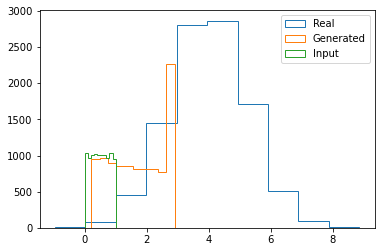

Stage 1 (Epoch: 200)
Mean and Std of Real: (4.0014315364388935, 1.2673775585946576)
Mean and Std of Gen: (3.7032487, 1.1326718)


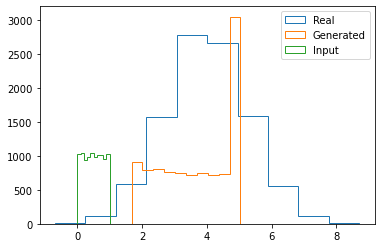

Stage 2 (Epoch: 400)
Mean and Std of Real: (3.9979005928877682, 1.2448114485619861)
Mean and Std of Gen: (3.8705773, 1.1399548)


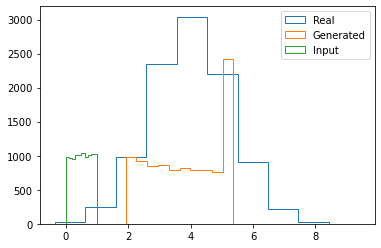

Stage 3 (Epoch: 600)
Mean and Std of Real: (3.9806126205688925, 1.240581781638501)
Mean and Std of Gen: (3.5099332, 1.1118305)


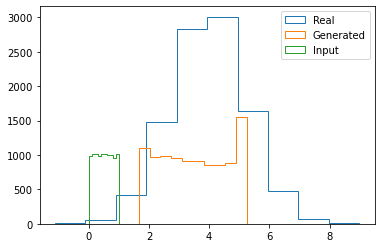

Stage 4 (Epoch: 800)
Mean and Std of Real: (3.979989725987226, 1.2474943102252354)
Mean and Std of Gen: (3.4901378, 1.1582992)


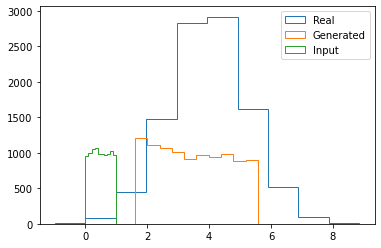

Stage 5 (Epoch: 1000)
Mean and Std of Real: (4.001824177215156, 1.2402370648169467)
Mean and Std of Gen: (3.1094165, 1.2943465)


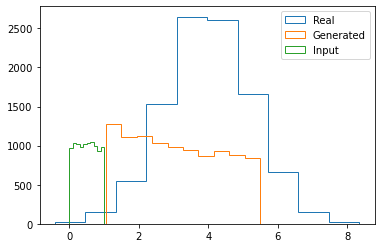

Stage 6 (Epoch: 1200)
Mean and Std of Real: (3.992686246670853, 1.2538373869631303)
Mean and Std of Gen: (3.323356, 1.0645227)


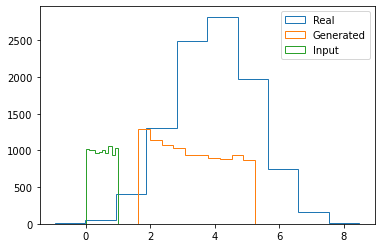

Stage 7 (Epoch: 1400)
Mean and Std of Real: (4.013623467890724, 1.2487862601726096)
Mean and Std of Gen: (4.6290264, 0.80697054)


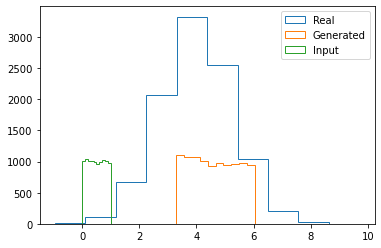

Stage 8 (Epoch: 1600)
Mean and Std of Real: (3.9997481175555527, 1.2519081861225523)
Mean and Std of Gen: (3.4616046, 1.245)


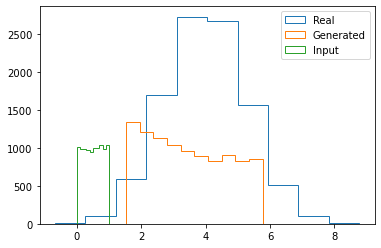

Stage 9 (Epoch: 1800)
Mean and Std of Real: (4.000972884528227, 1.2380916423679689)
Mean and Std of Gen: (3.3147438, 1.1390196)


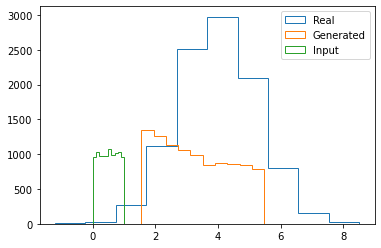

Stage 10 (Epoch: 2000)
Mean and Std of Real: (3.997655516812787, 1.2620780812927173)
Mean and Std of Gen: (3.5108047, 1.2507701)


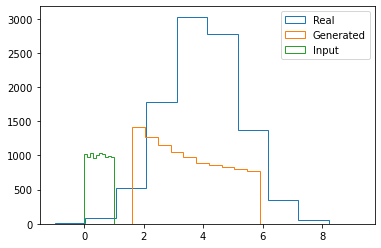

Stage 11 (Epoch: 2200)
Mean and Std of Real: (4.007959832763008, 1.2415390061301503)
Mean and Std of Gen: (3.2229176, 1.0868343)


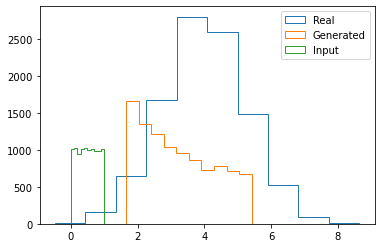

Stage 12 (Epoch: 2400)
Mean and Std of Real: (4.022181493081151, 1.2536191368445613)
Mean and Std of Gen: (4.0824776, 1.000553)


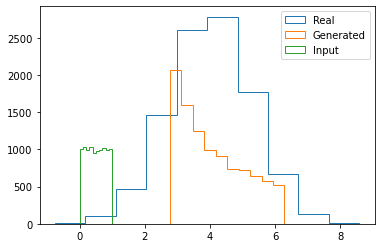

Stage 13 (Epoch: 2600)
Mean and Std of Real: (3.9998067370925106, 1.2490933730220328)
Mean and Std of Gen: (4.252699, 1.3154379)


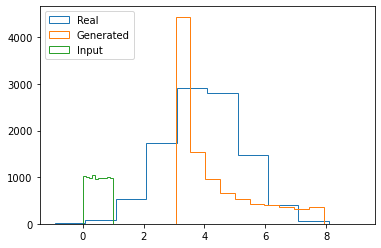

Stage 14 (Epoch: 2800)
Mean and Std of Real: (4.005246548520914, 1.2552584658020671)
Mean and Std of Gen: (5.490507, 1.4231225)


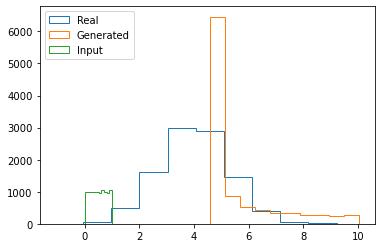

Stage 15 (Epoch: 3000)
Mean and Std of Real: (4.006271637782252, 1.2493336146808003)
Mean and Std of Gen: (6.6184764, 1.4445276)


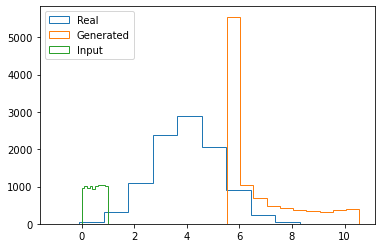

Stage 16 (Epoch: 3200)
Mean and Std of Real: (3.993462960101159, 1.2365242184443148)
Mean and Std of Gen: (6.6560564, 1.6958464)


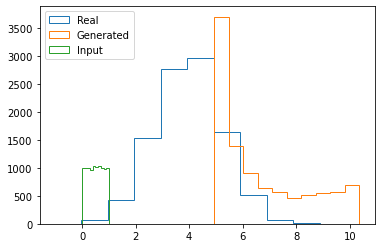

Stage 17 (Epoch: 3400)
Mean and Std of Real: (4.008298979901858, 1.240921054583464)
Mean and Std of Gen: (5.3208175, 1.3153917)


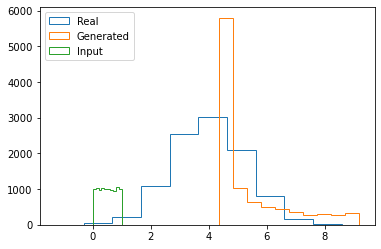

Stage 18 (Epoch: 3600)
Mean and Std of Real: (3.9952318132205007, 1.251072635283724)
Mean and Std of Gen: (5.1515155, 1.4198484)


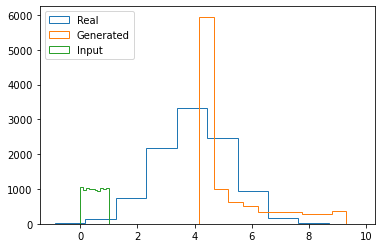

Stage 19 (Epoch: 3800)
Mean and Std of Real: (3.9905602679295473, 1.2672677631449565)
Mean and Std of Gen: (5.629178, 1.5697695)


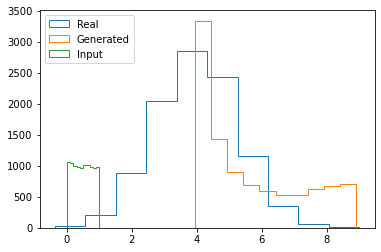

Stage 20 (Epoch: 4000)
Mean and Std of Real: (4.005303022897431, 1.2473352781636333)
Mean and Std of Gen: (4.4631505, 1.419301)


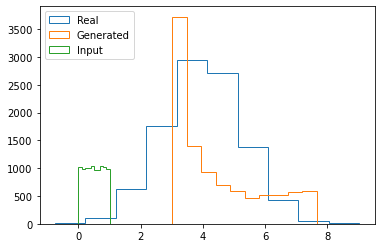

Stage 21 (Epoch: 4200)
Mean and Std of Real: (4.013732160776732, 1.2534659270944524)
Mean and Std of Gen: (3.7550864, 1.2735248)


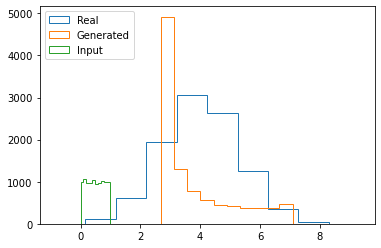

Stage 22 (Epoch: 4400)
Mean and Std of Real: (3.9979173756948176, 1.2451989983512441)
Mean and Std of Gen: (4.1028123, 1.3214519)


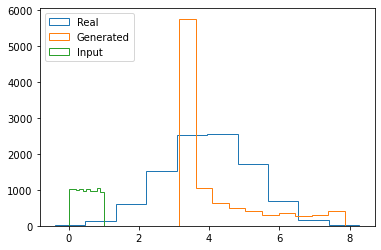

Stage 23 (Epoch: 4600)
Mean and Std of Real: (3.9989085473796266, 1.2459031473490407)
Mean and Std of Gen: (4.373141, 1.3489066)


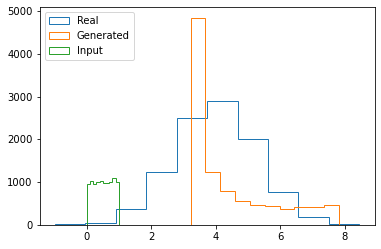

Stage 24 (Epoch: 4800)
Mean and Std of Real: (3.9866808595495407, 1.2493643122574185)
Mean and Std of Gen: (4.059436, 1.2558101)


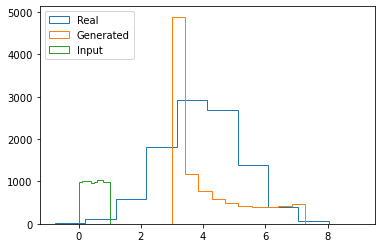

Stage 25 (Epoch: 5000)
Mean and Std of Real: (3.9887796907455444, 1.2610399676507325)
Mean and Std of Gen: (4.0407596, 1.2362226)


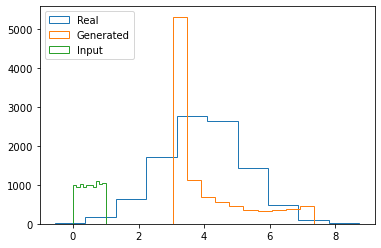

Stage 26 (Epoch: 5200)
Mean and Std of Real: (3.9875269990455107, 1.2559848183809785)
Mean and Std of Gen: (4.1708183, 1.2272816)


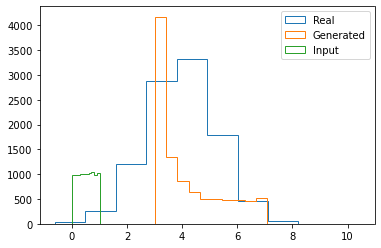

Stage 27 (Epoch: 5400)
Mean and Std of Real: (4.006195828101796, 1.2555371515688856)
Mean and Std of Gen: (3.775564, 1.221427)


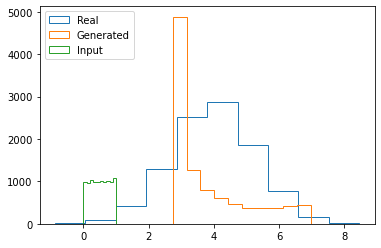

Stage 28 (Epoch: 5600)
Mean and Std of Real: (4.003217922801211, 1.2587433676634006)
Mean and Std of Gen: (4.174886, 1.2947044)


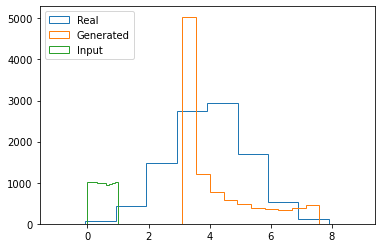

Stage 29 (Epoch: 5800)
Mean and Std of Real: (3.9789456669286425, 1.2419789488416182)
Mean and Std of Gen: (4.46874, 1.2366709)


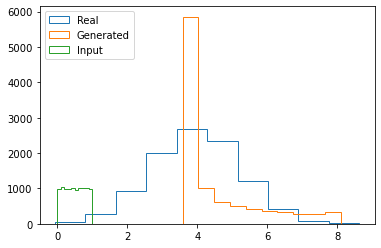

Stage 30 (Epoch: 6000)
Mean and Std of Real: (4.004492887580126, 1.2601491537639178)
Mean and Std of Gen: (4.440761, 1.2962592)


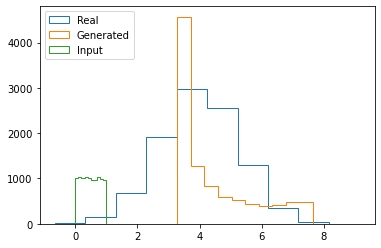

Stage 31 (Epoch: 6200)
Mean and Std of Real: (3.998165588878662, 1.250121097928232)
Mean and Std of Gen: (3.9018536, 1.2886628)


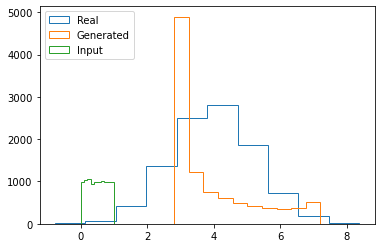

Stage 32 (Epoch: 6400)
Mean and Std of Real: (3.975669073946082, 1.2533009044185377)
Mean and Std of Gen: (3.8823345, 1.3152922)


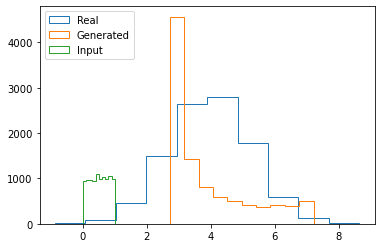

Stage 33 (Epoch: 6600)
Mean and Std of Real: (4.001310157185953, 1.2594822851100675)
Mean and Std of Gen: (3.702597, 1.2611849)


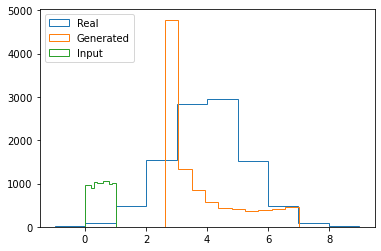

Stage 34 (Epoch: 6800)
Mean and Std of Real: (3.98658490037917, 1.2792327104452414)
Mean and Std of Gen: (3.8887846, 1.1725407)


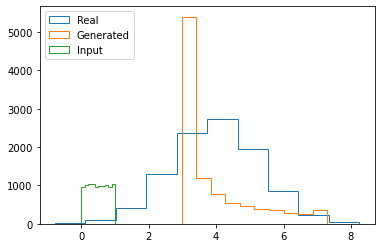

Stage 35 (Epoch: 7000)
Mean and Std of Real: (3.995631045181671, 1.2405333466800221)
Mean and Std of Gen: (4.0531516, 1.1165053)


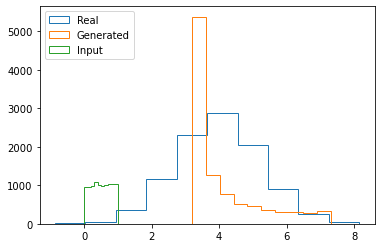

Stage 36 (Epoch: 7200)
Mean and Std of Real: (4.015861112109809, 1.266997585875604)
Mean and Std of Gen: (4.2177515, 1.2376564)


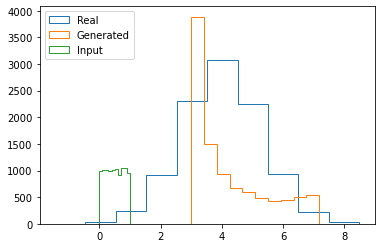

Stage 37 (Epoch: 7400)
Mean and Std of Real: (3.983109703347087, 1.255571211675802)
Mean and Std of Gen: (4.0440617, 1.0821239)


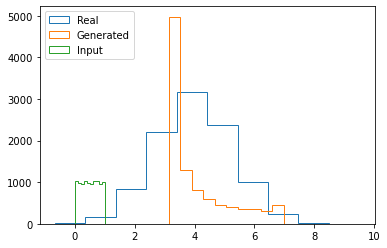

Stage 38 (Epoch: 7600)
Mean and Std of Real: (4.00733380909249, 1.2559579891102133)
Mean and Std of Gen: (4.1853666, 1.2537466)


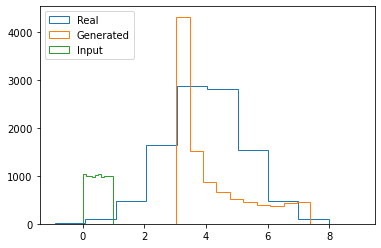

Stage 39 (Epoch: 7800)
Mean and Std of Real: (4.001399168114823, 1.251344454520401)
Mean and Std of Gen: (3.5997937, 1.3597364)


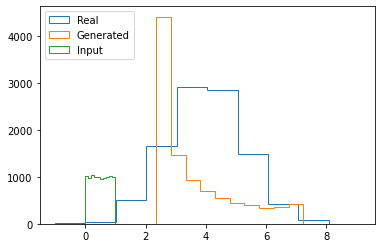

Stage 40 (Epoch: 8000)
Mean and Std of Real: (3.9806819182164253, 1.2408302813858785)
Mean and Std of Gen: (4.0252514, 1.3205373)


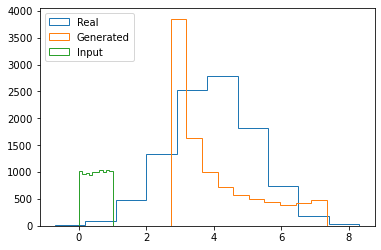

Stage 41 (Epoch: 8200)
Mean and Std of Real: (4.020011849984576, 1.2416576308822853)
Mean and Std of Gen: (4.311153, 1.1362283)


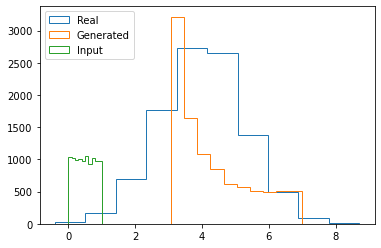

Stage 42 (Epoch: 8400)
Mean and Std of Real: (4.007226540858359, 1.2519115685707523)
Mean and Std of Gen: (4.0541487, 1.2554224)


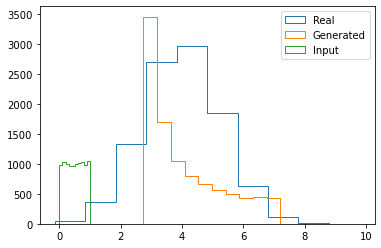

Stage 43 (Epoch: 8600)
Mean and Std of Real: (3.97677169702735, 1.2560410370661503)
Mean and Std of Gen: (3.8447645, 1.224099)


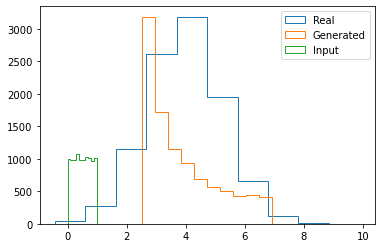

Stage 44 (Epoch: 8800)
Mean and Std of Real: (4.024466525256982, 1.2541085085085402)
Mean and Std of Gen: (3.7836223, 1.3500568)


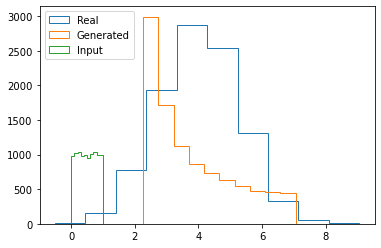

Stage 45 (Epoch: 9000)
Mean and Std of Real: (4.008570970243037, 1.2577607517264031)
Mean and Std of Gen: (4.065677, 1.230547)


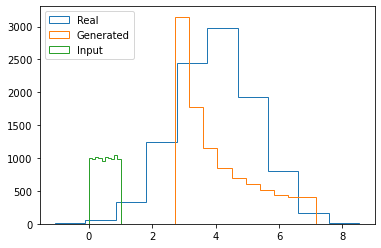

Stage 46 (Epoch: 9200)
Mean and Std of Real: (4.009364325019171, 1.251600703875346)
Mean and Std of Gen: (3.742414, 1.2625049)


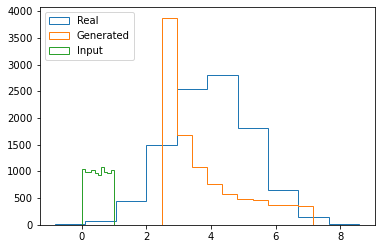

Stage 47 (Epoch: 9400)
Mean and Std of Real: (3.9991832819748394, 1.239577766100836)
Mean and Std of Gen: (4.2693195, 1.0904005)


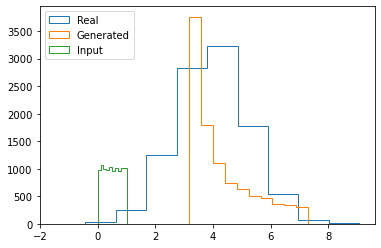

Stage 48 (Epoch: 9600)
Mean and Std of Real: (3.992343502210961, 1.2600977706929712)
Mean and Std of Gen: (4.202754, 1.2353668)


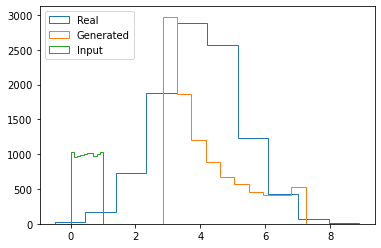

Stage 49 (Epoch: 9800)
Mean and Std of Real: (3.9919551641507445, 1.255641869210689)
Mean and Std of Gen: (4.0388713, 1.2284663)


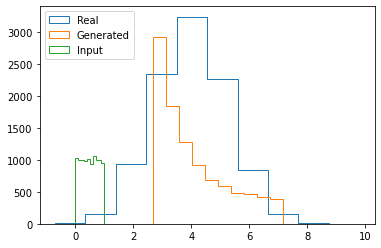

Stage 50 (Epoch: 10000)
Mean and Std of Real: (4.003609047776315, 1.2407069340358745)
Mean and Std of Gen: (4.1415796, 1.0233257)


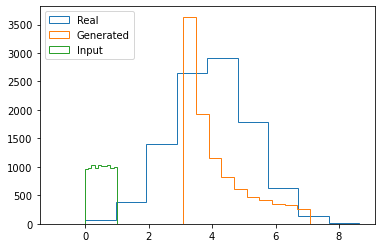

Stage 51 (Epoch: 10200)
Mean and Std of Real: (4.008635493184136, 1.2558311884009372)
Mean and Std of Gen: (4.1036444, 1.2015359)


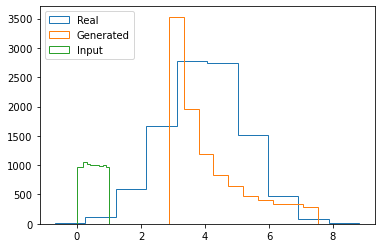

Stage 52 (Epoch: 10400)
Mean and Std of Real: (3.9825469482709157, 1.252209662707575)
Mean and Std of Gen: (4.333857, 1.153333)


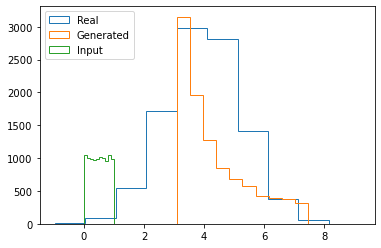

Stage 53 (Epoch: 10600)
Mean and Std of Real: (4.007151381738989, 1.2514943496010285)
Mean and Std of Gen: (4.2490177, 1.2150129)


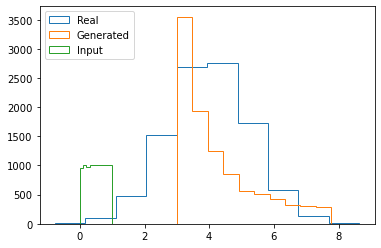

Stage 54 (Epoch: 10800)
Mean and Std of Real: (4.013747717254248, 1.2457606709333153)
Mean and Std of Gen: (4.0474195, 0.98819435)


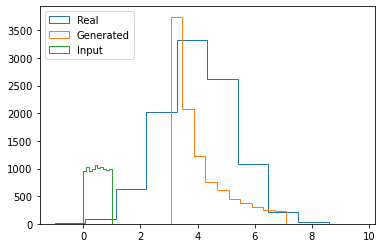

Stage 55 (Epoch: 11000)
Mean and Std of Real: (3.986885907391174, 1.253053883388152)
Mean and Std of Gen: (4.297277, 1.0509294)


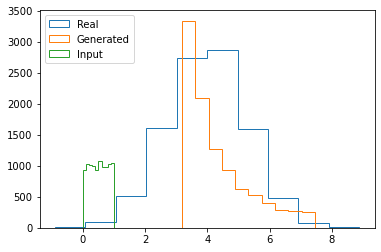

Stage 56 (Epoch: 11200)
Mean and Std of Real: (4.031810345536213, 1.2575729058895369)
Mean and Std of Gen: (3.9919796, 1.1705862)


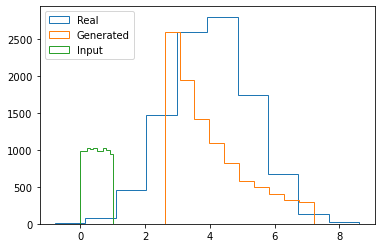

Stage 57 (Epoch: 11400)
Mean and Std of Real: (3.9916431260095195, 1.2603494432717304)
Mean and Std of Gen: (4.337712, 1.1548094)


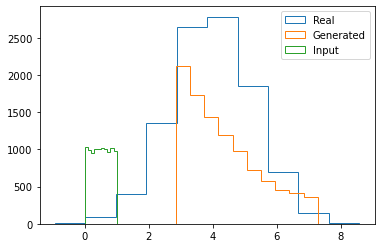

Stage 58 (Epoch: 11600)
Mean and Std of Real: (3.9716371176445247, 1.2673452922789172)
Mean and Std of Gen: (4.0958815, 1.1863729)


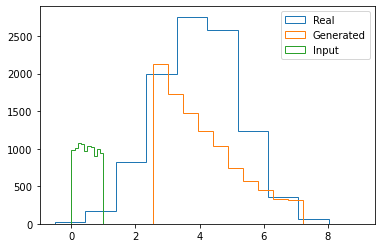

Stage 59 (Epoch: 11800)
Mean and Std of Real: (4.001864200899886, 1.2494549988025652)
Mean and Std of Gen: (3.7970452, 1.2726767)


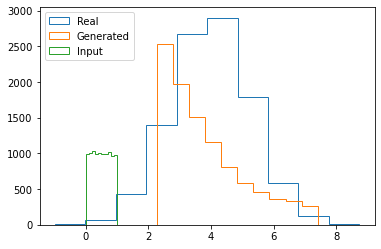

Stage 60 (Epoch: 12000)
Mean and Std of Real: (3.993456062339046, 1.2556523250566656)
Mean and Std of Gen: (4.009665, 1.2110386)


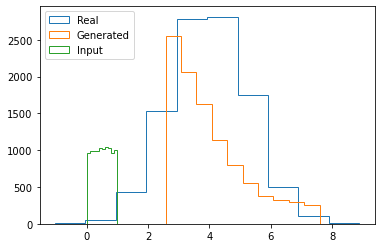

Stage 61 (Epoch: 12200)
Mean and Std of Real: (3.9834237882043824, 1.2463812940784122)
Mean and Std of Gen: (4.2545595, 1.2280773)


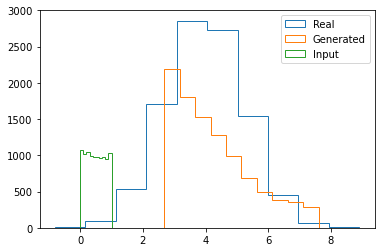

Stage 62 (Epoch: 12400)
Mean and Std of Real: (3.989558746677423, 1.258101894736807)
Mean and Std of Gen: (4.1044393, 1.2739198)


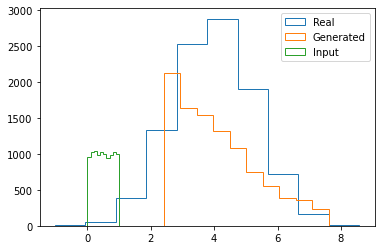

Stage 63 (Epoch: 12600)
Mean and Std of Real: (4.003400695943545, 1.2576329732629046)
Mean and Std of Gen: (3.7616816, 1.2758079)


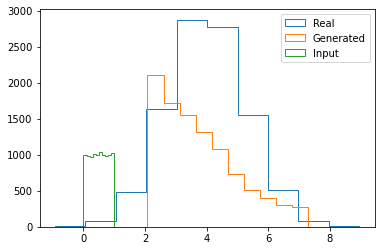

Stage 64 (Epoch: 12800)
Mean and Std of Real: (4.00300404081252, 1.2388440835215317)
Mean and Std of Gen: (4.112766, 1.2545089)


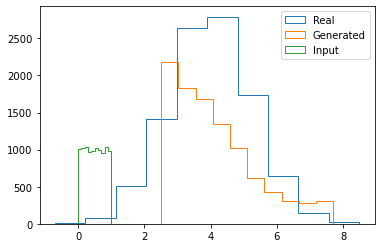

Stage 65 (Epoch: 13000)
Mean and Std of Real: (4.011482803648902, 1.247499614761541)
Mean and Std of Gen: (4.1657467, 1.2007438)


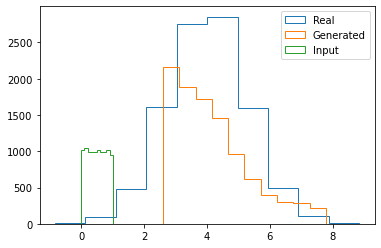

Stage 66 (Epoch: 13200)
Mean and Std of Real: (3.997407128927342, 1.248210072158823)
Mean and Std of Gen: (3.9488027, 1.3779253)


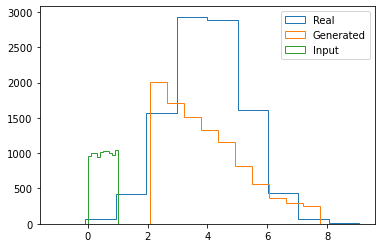

Stage 67 (Epoch: 13400)
Mean and Std of Real: (3.9880116116836093, 1.245329502838454)
Mean and Std of Gen: (4.033925, 1.20939)


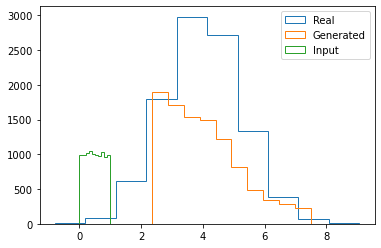

Stage 68 (Epoch: 13600)
Mean and Std of Real: (3.993037138651167, 1.2436875148675788)
Mean and Std of Gen: (3.978769, 1.1279082)


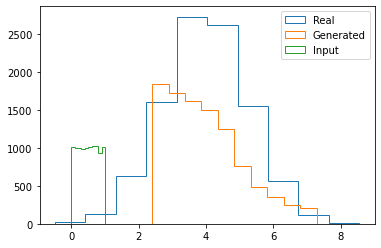

Stage 69 (Epoch: 13800)
Mean and Std of Real: (4.030285456406385, 1.2397906190968828)
Mean and Std of Gen: (3.8608837, 1.2674425)


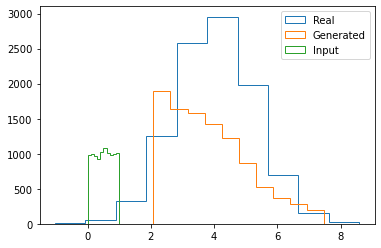

Stage 70 (Epoch: 14000)
Mean and Std of Real: (3.990273958332437, 1.2552903832203872)
Mean and Std of Gen: (4.049425, 1.2590919)


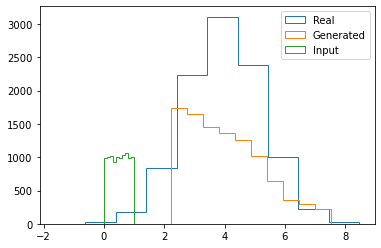

Stage 71 (Epoch: 14200)
Mean and Std of Real: (4.016987516517038, 1.2666990808983334)
Mean and Std of Gen: (4.1013274, 1.1464796)


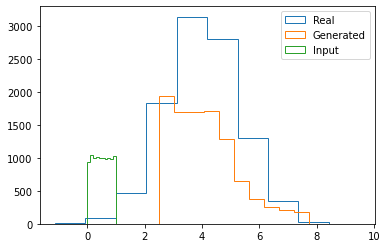

Stage 72 (Epoch: 14400)
Mean and Std of Real: (4.005844617400313, 1.237951213810983)
Mean and Std of Gen: (3.5774024, 1.3178462)


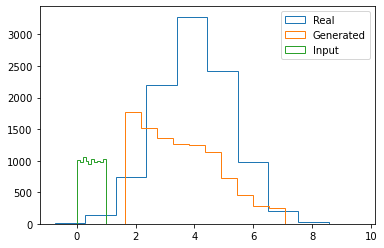

Stage 73 (Epoch: 14600)
Mean and Std of Real: (4.015792606117746, 1.250958399862396)
Mean and Std of Gen: (4.1157336, 1.1793084)


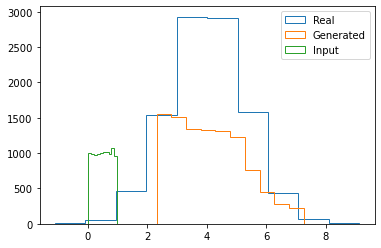

Stage 74 (Epoch: 14800)
Mean and Std of Real: (4.021064629321593, 1.2391013758632339)
Mean and Std of Gen: (4.3149424, 1.1883276)


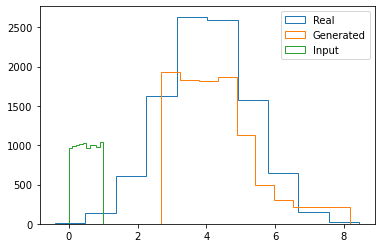

Stage 75 (Epoch: 15000)
Mean and Std of Real: (4.002652604408285, 1.2544456885380546)
Mean and Std of Gen: (4.5127726, 1.0991669)


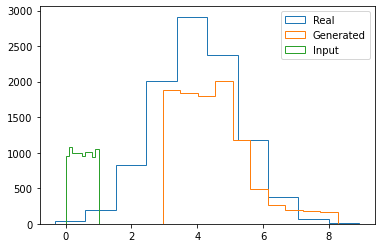

Stage 76 (Epoch: 15200)
Mean and Std of Real: (3.992801368409363, 1.260568111647116)
Mean and Std of Gen: (3.8855507, 1.202141)


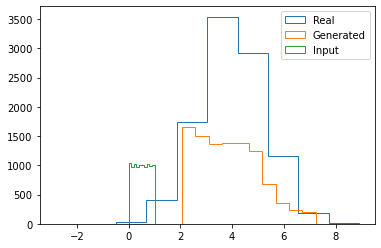

Stage 77 (Epoch: 15400)
Mean and Std of Real: (3.99480278265257, 1.2488278165812103)
Mean and Std of Gen: (3.835632, 1.4333857)


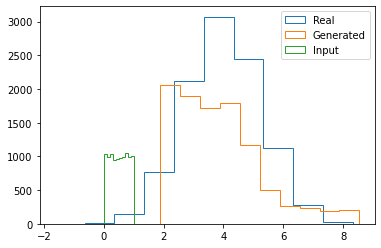

Stage 78 (Epoch: 15600)
Mean and Std of Real: (3.9926034366195227, 1.2554259878139826)
Mean and Std of Gen: (4.258855, 1.1577896)


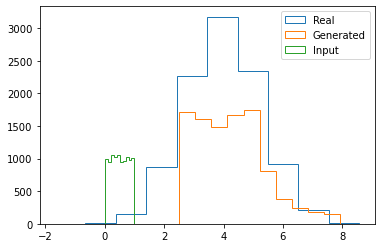

Stage 79 (Epoch: 15800)
Mean and Std of Real: (3.9888272323476626, 1.2464793771242249)
Mean and Std of Gen: (4.188482, 1.2655132)


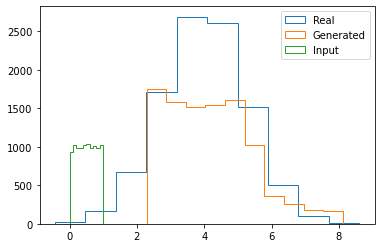

Stage 80 (Epoch: 16000)
Mean and Std of Real: (3.9780935258681036, 1.2459533735866177)
Mean and Std of Gen: (4.003623, 1.2875096)


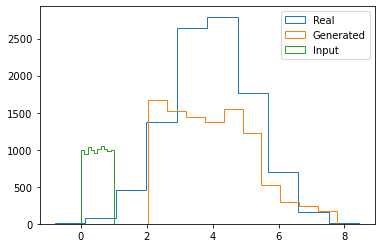

Stage 81 (Epoch: 16200)
Mean and Std of Real: (4.003787372608816, 1.2584088941657077)
Mean and Std of Gen: (3.8133328, 1.240503)


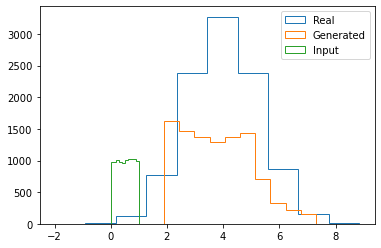

Stage 82 (Epoch: 16400)
Mean and Std of Real: (3.999001955662121, 1.2563760288743226)
Mean and Std of Gen: (3.845667, 1.2504882)


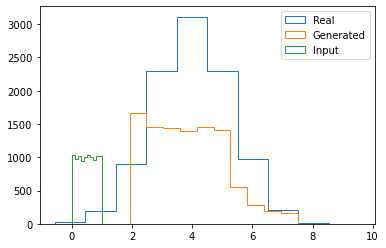

Stage 83 (Epoch: 16600)
Mean and Std of Real: (3.990706020273118, 1.249974197315688)
Mean and Std of Gen: (3.8235312, 1.3457375)


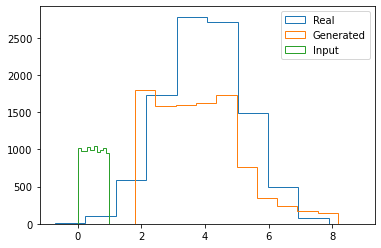

Stage 84 (Epoch: 16800)
Mean and Std of Real: (3.996295625702139, 1.2561393902617202)
Mean and Std of Gen: (3.8220227, 1.3323643)


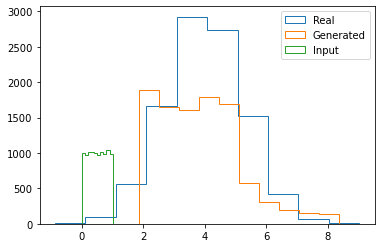

Stage 85 (Epoch: 17000)
Mean and Std of Real: (4.009577850577243, 1.2474955266693772)
Mean and Std of Gen: (3.9214141, 1.2310115)


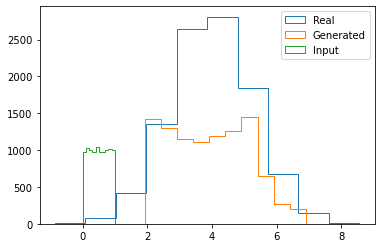

Stage 86 (Epoch: 17200)
Mean and Std of Real: (3.9827830600474976, 1.2584917321346458)
Mean and Std of Gen: (3.7430031, 1.2196269)


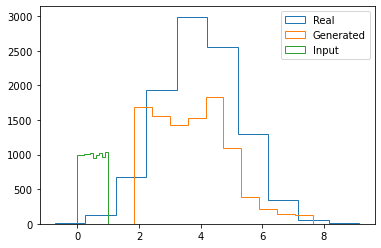

Stage 87 (Epoch: 17400)
Mean and Std of Real: (3.9997677643503615, 1.2392964327405518)
Mean and Std of Gen: (4.4520373, 1.216146)


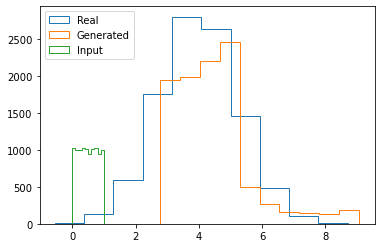

Stage 88 (Epoch: 17600)
Mean and Std of Real: (4.006851678188515, 1.2505460421309298)
Mean and Std of Gen: (4.2912607, 1.3255696)


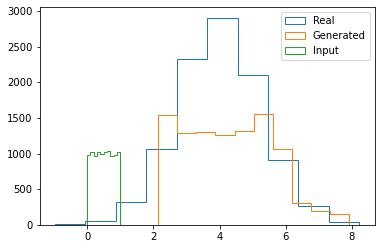

Stage 89 (Epoch: 17800)
Mean and Std of Real: (3.9833469576471265, 1.253918404701579)
Mean and Std of Gen: (3.7811987, 1.2757584)


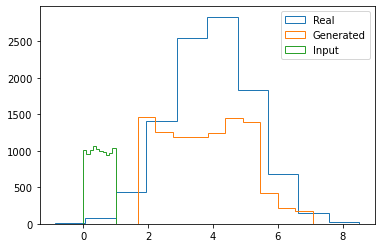

Stage 90 (Epoch: 18000)
Mean and Std of Real: (4.003004821169868, 1.240371689373388)
Mean and Std of Gen: (3.7223418, 1.2753274)


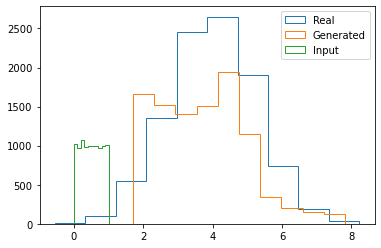

Stage 91 (Epoch: 18200)
Mean and Std of Real: (3.9941893837598634, 1.266804571367471)
Mean and Std of Gen: (3.9878726, 1.1683468)


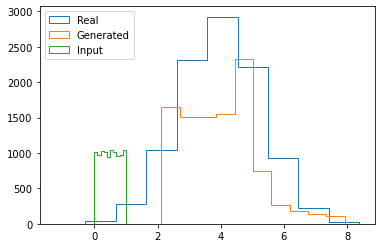

Stage 92 (Epoch: 18400)
Mean and Std of Real: (3.9985406949254982, 1.2395904707913588)
Mean and Std of Gen: (3.95484, 1.2032276)


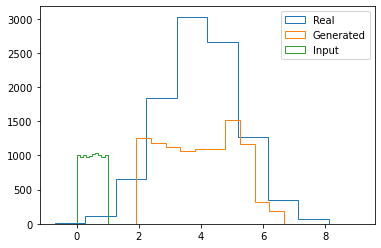

Stage 93 (Epoch: 18600)
Mean and Std of Real: (3.989392683718007, 1.261850249039924)
Mean and Std of Gen: (3.5918727, 1.2249577)


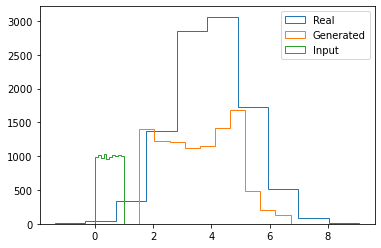

Stage 94 (Epoch: 18800)
Mean and Std of Real: (4.002015770388387, 1.2594029956514943)
Mean and Std of Gen: (4.2220116, 1.2662055)


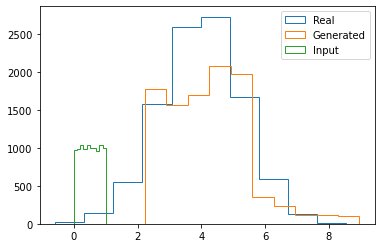

Stage 95 (Epoch: 19000)
Mean and Std of Real: (3.9937305004755728, 1.2554954057079883)
Mean and Std of Gen: (4.441211, 1.1137795)


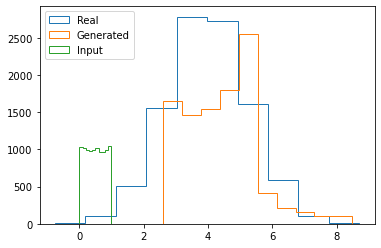

Stage 96 (Epoch: 19200)
Mean and Std of Real: (4.005813768287241, 1.2506926556712483)
Mean and Std of Gen: (4.0828233, 1.2533942)


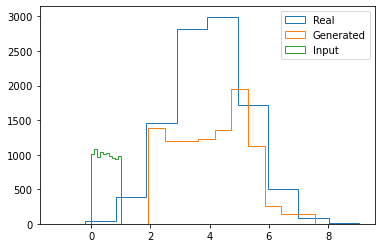

Stage 97 (Epoch: 19400)
Mean and Std of Real: (4.000685085541348, 1.2433260196857379)
Mean and Std of Gen: (4.0581274, 1.2434144)


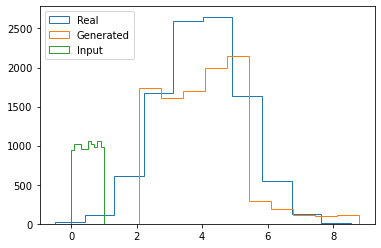

Stage 98 (Epoch: 19600)
Mean and Std of Real: (4.000708826431534, 1.2369870411606525)
Mean and Std of Gen: (4.110769, 1.31204)


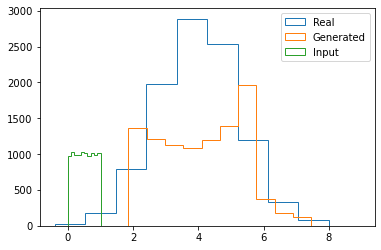

Stage 99 (Epoch: 19800)
Mean and Std of Real: (3.974105419440091, 1.253407504561763)
Mean and Std of Gen: (3.9545698, 1.1999149)


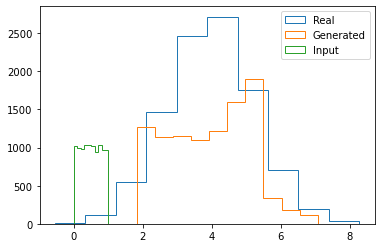

Stage 100 (Epoch: 20000)
Mean and Std of Real: (3.9865730854142414, 1.2593728045825898)
Mean and Std of Gen: (4.14436, 1.2630697)


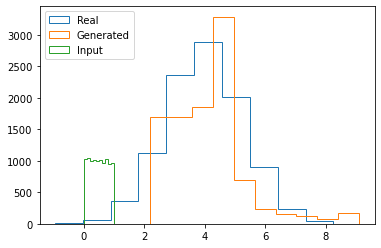

Stage 101 (Epoch: 20200)
Mean and Std of Real: (3.998825007280015, 1.2512351772391634)
Mean and Std of Gen: (4.077535, 1.3231997)


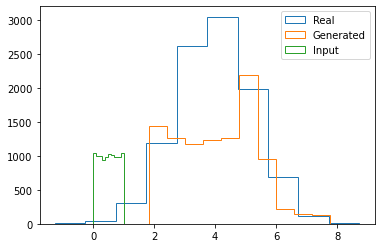

Stage 102 (Epoch: 20400)
Mean and Std of Real: (4.0014936709645585, 1.2581594294682343)
Mean and Std of Gen: (3.7246816, 1.2996655)


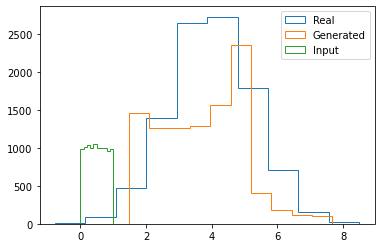

Stage 103 (Epoch: 20600)
Mean and Std of Real: (4.005601599449681, 1.2385388606786587)
Mean and Std of Gen: (3.8711011, 1.3228499)


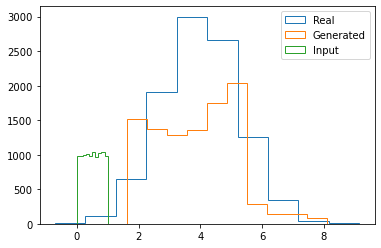

Stage 104 (Epoch: 20800)
Mean and Std of Real: (4.007517532450996, 1.2541535441178322)
Mean and Std of Gen: (3.4633594, 1.3822355)


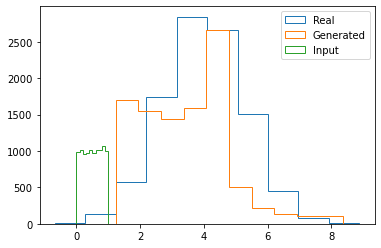

Stage 105 (Epoch: 21000)
Mean and Std of Real: (3.983337066828294, 1.244721305908491)
Mean and Std of Gen: (4.0027595, 1.2340891)


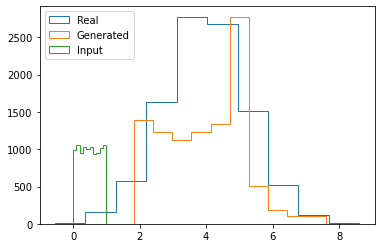

Stage 106 (Epoch: 21200)
Mean and Std of Real: (3.991147322504882, 1.2530954873126214)
Mean and Std of Gen: (4.106632, 1.2411469)


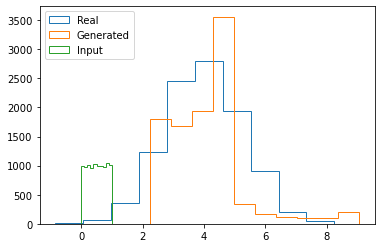

Stage 107 (Epoch: 21400)
Mean and Std of Real: (4.003024901920392, 1.2594937969573399)
Mean and Std of Gen: (4.163544, 1.297372)


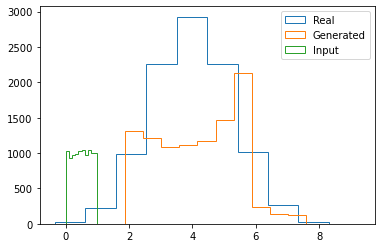

Stage 108 (Epoch: 21600)
Mean and Std of Real: (3.9960517926163304, 1.2417655750219085)
Mean and Std of Gen: (4.087714, 1.2074661)


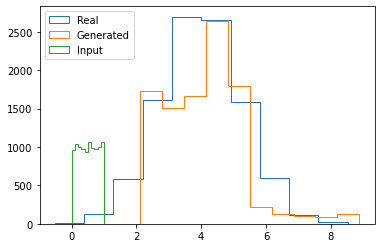

Stage 109 (Epoch: 21800)
Mean and Std of Real: (4.0087467682002895, 1.250007132141196)
Mean and Std of Gen: (4.2713084, 1.2524513)


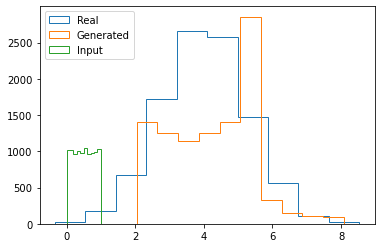

Stage 110 (Epoch: 22000)
Mean and Std of Real: (4.015453950489459, 1.2468268610537845)
Mean and Std of Gen: (3.82206, 1.1654625)


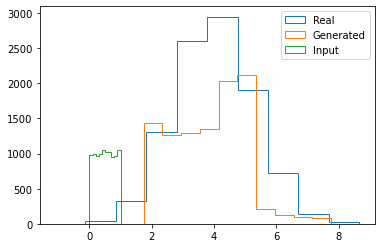

Stage 111 (Epoch: 22200)
Mean and Std of Real: (3.9953158814568916, 1.2553988728829912)
Mean and Std of Gen: (4.1790915, 1.0821751)


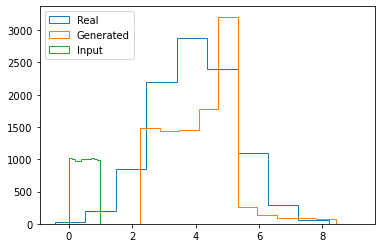

Stage 112 (Epoch: 22400)
Mean and Std of Real: (3.9990551275022326, 1.2544318765994178)
Mean and Std of Gen: (4.293621, 1.0952287)


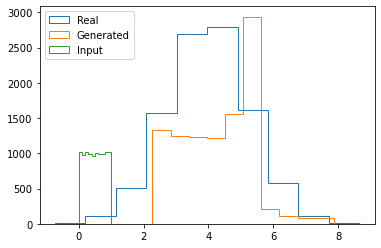

Stage 113 (Epoch: 22600)
Mean and Std of Real: (3.9840434902786446, 1.2417584707039848)
Mean and Std of Gen: (4.032448, 1.1925086)


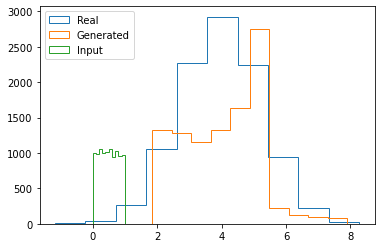

Stage 114 (Epoch: 22800)
Mean and Std of Real: (4.006276084442329, 1.247073358544352)
Mean and Std of Gen: (4.141674, 1.2761784)


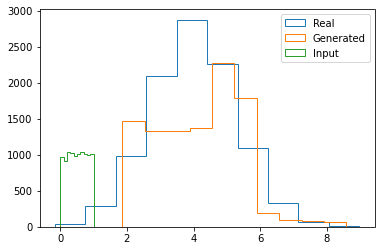

Stage 115 (Epoch: 23000)
Mean and Std of Real: (3.987110556967429, 1.2465383230865488)
Mean and Std of Gen: (4.1788054, 1.22212)


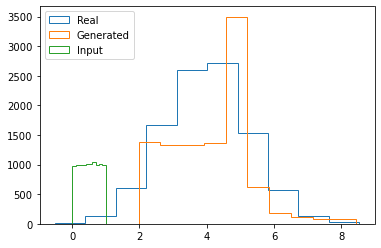

Stage 116 (Epoch: 23200)
Mean and Std of Real: (4.012606986596514, 1.249249099587111)
Mean and Std of Gen: (4.2136993, 1.2443501)


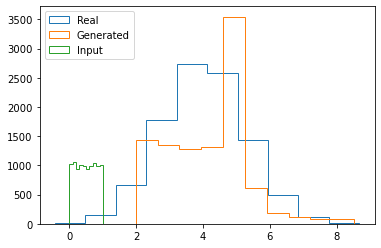

Stage 117 (Epoch: 23400)
Mean and Std of Real: (4.020300636093293, 1.2458420321299066)
Mean and Std of Gen: (3.7659621, 1.2903361)


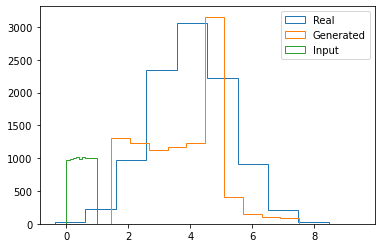

Stage 118 (Epoch: 23600)
Mean and Std of Real: (3.998790323171878, 1.254564909108388)
Mean and Std of Gen: (4.1963735, 1.1955496)


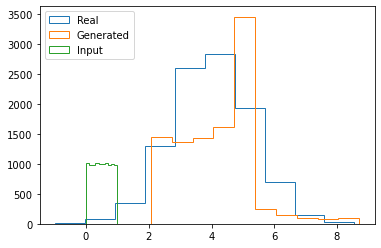

Stage 119 (Epoch: 23800)
Mean and Std of Real: (3.9869123708024388, 1.2347408682596797)
Mean and Std of Gen: (3.816, 1.2986972)


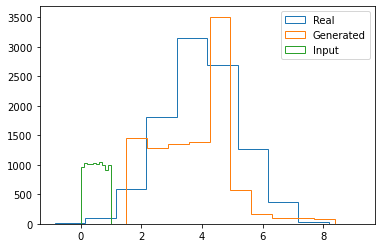

Stage 120 (Epoch: 24000)
Mean and Std of Real: (3.975555583742116, 1.263676182882861)
Mean and Std of Gen: (3.9924653, 1.2782875)


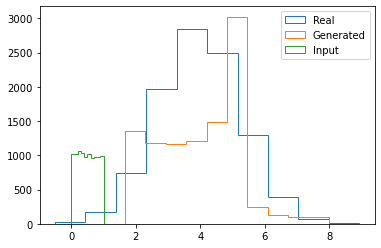

Stage 121 (Epoch: 24200)
Mean and Std of Real: (3.9960663394496847, 1.232264138589566)
Mean and Std of Gen: (4.0708704, 1.2390474)


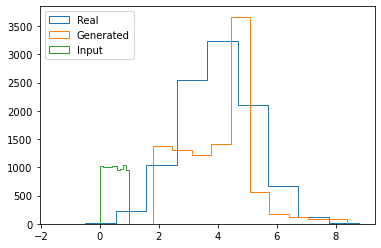

Stage 122 (Epoch: 24400)
Mean and Std of Real: (3.990975357476821, 1.239415514661138)
Mean and Std of Gen: (3.9261837, 1.2107744)


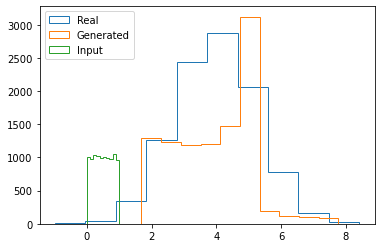

Stage 123 (Epoch: 24600)
Mean and Std of Real: (3.984100336057636, 1.2413015079809822)
Mean and Std of Gen: (4.254998, 1.143602)


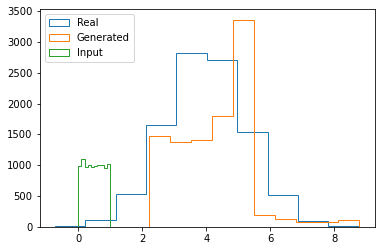

Stage 124 (Epoch: 24800)
Mean and Std of Real: (3.9971471588097294, 1.2432325369919899)
Mean and Std of Gen: (4.0385427, 1.2472169)


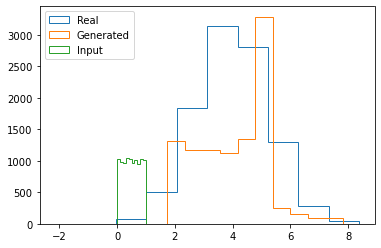

Stage 125 (Epoch: 25000)
Mean and Std of Real: (4.0069676958507845, 1.2630761046470502)
Mean and Std of Gen: (3.8990195, 1.3291881)


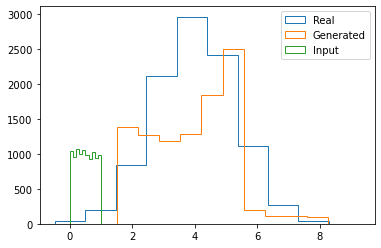

Stage 126 (Epoch: 25200)
Mean and Std of Real: (3.993917350995915, 1.2417206758433035)
Mean and Std of Gen: (4.018608, 1.3187746)


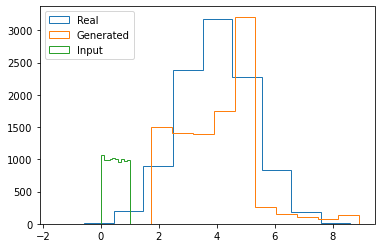

Stage 127 (Epoch: 25400)
Mean and Std of Real: (4.000693311418988, 1.2464125649178834)
Mean and Std of Gen: (3.9889219, 1.2470524)


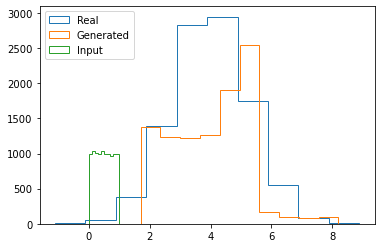

Stage 128 (Epoch: 25600)
Mean and Std of Real: (4.00291661238989, 1.2464851196498339)
Mean and Std of Gen: (4.0872607, 1.2696738)


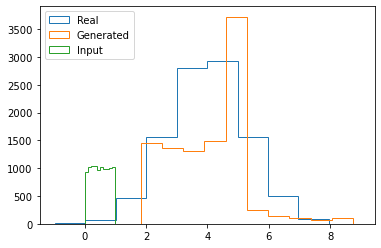

Stage 129 (Epoch: 25800)
Mean and Std of Real: (4.00940779616399, 1.2565076113422171)
Mean and Std of Gen: (4.112326, 1.2702957)


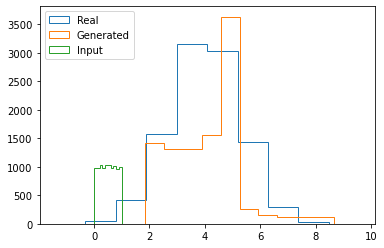

Stage 130 (Epoch: 26000)
Mean and Std of Real: (4.0022254130843296, 1.25230902110648)
Mean and Std of Gen: (3.8308692, 1.2891546)


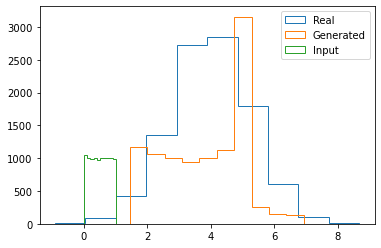

Stage 131 (Epoch: 26200)
Mean and Std of Real: (4.0111703331409645, 1.25968575443119)
Mean and Std of Gen: (4.021188, 1.1432049)


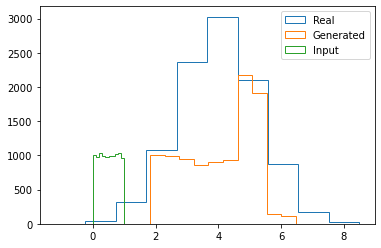

Stage 132 (Epoch: 26400)
Mean and Std of Real: (4.005648763698203, 1.2465640369975564)
Mean and Std of Gen: (3.7661223, 1.1872988)


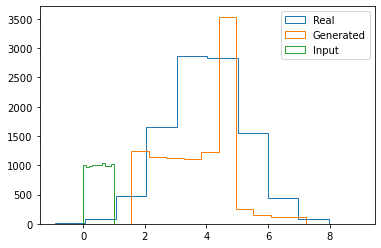

Stage 133 (Epoch: 26600)
Mean and Std of Real: (4.012481907653439, 1.2491712536679735)
Mean and Std of Gen: (3.957022, 1.287161)


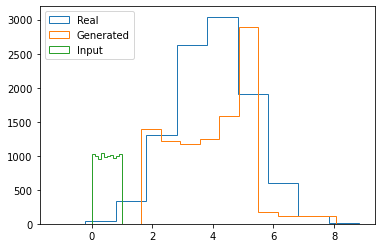

Stage 134 (Epoch: 26800)
Mean and Std of Real: (4.008310822117708, 1.2481379294258061)
Mean and Std of Gen: (3.9245763, 1.2464161)


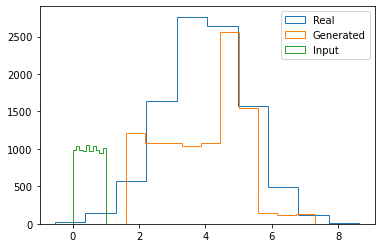

Stage 135 (Epoch: 27000)
Mean and Std of Real: (3.9814228300266388, 1.2427717664891649)
Mean and Std of Gen: (3.9048634, 1.2605851)


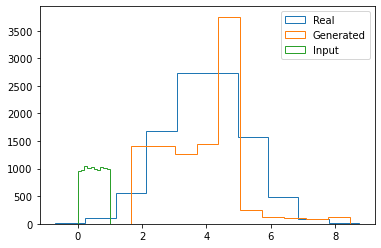

Stage 136 (Epoch: 27200)
Mean and Std of Real: (3.983290550749177, 1.2714141201759348)
Mean and Std of Gen: (4.2017155, 1.2422003)


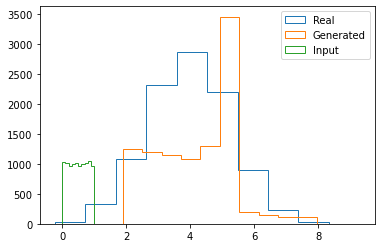

Stage 137 (Epoch: 27400)
Mean and Std of Real: (3.9929441366934655, 1.240453262074382)
Mean and Std of Gen: (3.6095195, 1.2917384)


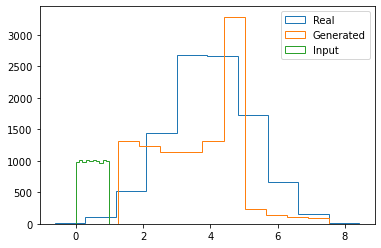

Stage 138 (Epoch: 27600)
Mean and Std of Real: (3.9744585543818793, 1.242097683340521)
Mean and Std of Gen: (4.023009, 1.2556317)


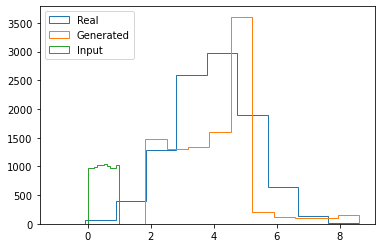

Stage 139 (Epoch: 27800)
Mean and Std of Real: (3.989387580353061, 1.2495121512686398)
Mean and Std of Gen: (3.9010699, 1.2563775)


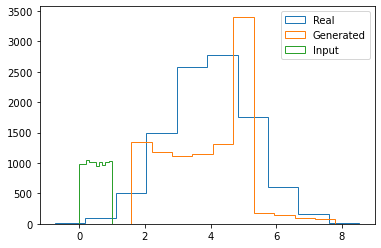

Stage 140 (Epoch: 28000)
Mean and Std of Real: (3.983851526256033, 1.2510180613034485)
Mean and Std of Gen: (4.1588273, 1.2309914)


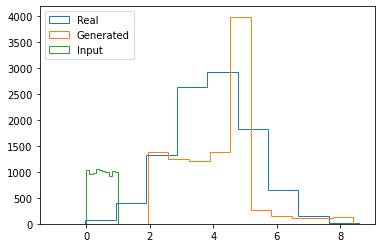

Stage 141 (Epoch: 28200)
Mean and Std of Real: (4.008296504647476, 1.2383127296450624)
Mean and Std of Gen: (3.8519437, 1.2834643)


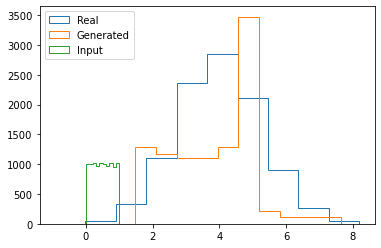

Stage 142 (Epoch: 28400)
Mean and Std of Real: (4.016585126784099, 1.2480797546931044)
Mean and Std of Gen: (4.001216, 1.2481997)


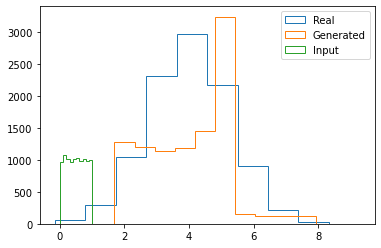

Stage 143 (Epoch: 28600)
Mean and Std of Real: (3.9762692736712633, 1.2625721431044008)
Mean and Std of Gen: (4.2701216, 1.2146522)


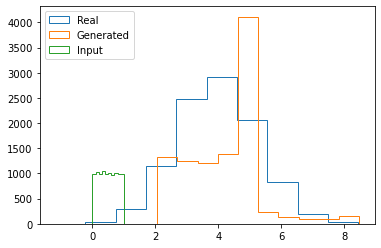

Stage 144 (Epoch: 28800)
Mean and Std of Real: (4.009805956020688, 1.2499370159740444)
Mean and Std of Gen: (4.150366, 1.254173)


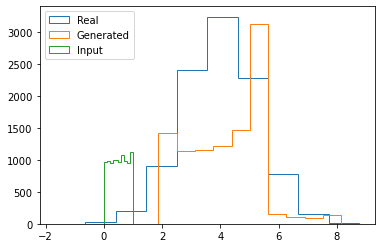

Stage 145 (Epoch: 29000)
Mean and Std of Real: (4.001436134809541, 1.2557615207218824)
Mean and Std of Gen: (3.9889476, 1.3092555)


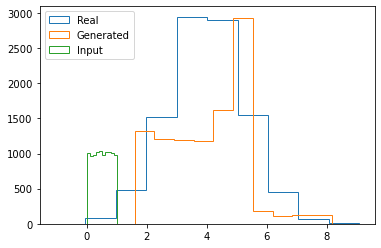

Stage 146 (Epoch: 29200)
Mean and Std of Real: (4.004638555786032, 1.2418309415180537)
Mean and Std of Gen: (4.122938, 1.2383771)


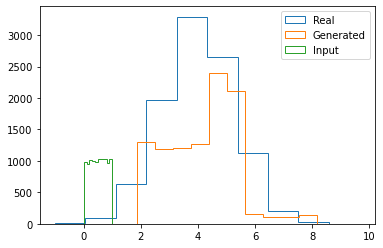

Stage 147 (Epoch: 29400)
Mean and Std of Real: (4.013022081099557, 1.261543578145683)
Mean and Std of Gen: (4.1143484, 1.1734726)


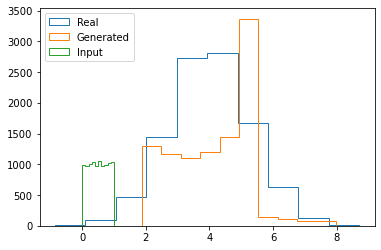

Stage 148 (Epoch: 29600)
Mean and Std of Real: (3.988025278750166, 1.2531166854014595)
Mean and Std of Gen: (4.073361, 1.301036)


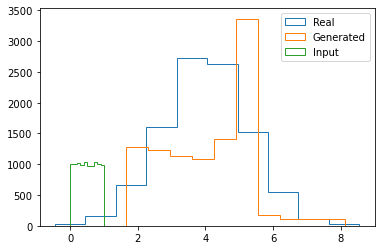

Stage 149 (Epoch: 29800)
Mean and Std of Real: (3.9870379129099063, 1.2575427609589915)
Mean and Std of Gen: (3.9199917, 1.3318756)


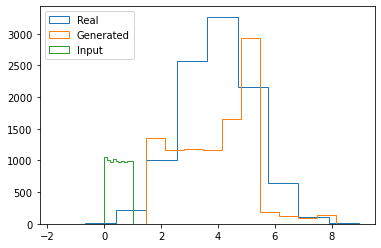

Stage 150 (Epoch: 30000)
Mean and Std of Real: (3.9751599952977594, 1.2413595522373373)
Mean and Std of Gen: (3.9520621, 1.2839379)


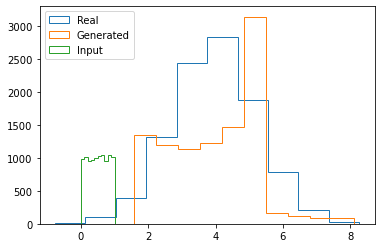

Stage 151 (Epoch: 30200)
Mean and Std of Real: (3.9981353497447234, 1.252699791437197)
Mean and Std of Gen: (4.0106144, 1.3186193)


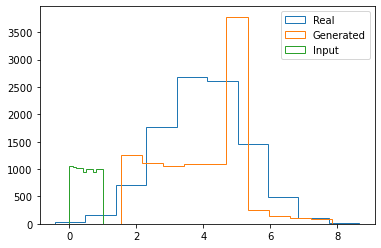

Stage 152 (Epoch: 30400)
Mean and Std of Real: (3.994697760195627, 1.233301534945981)
Mean and Std of Gen: (4.1037436, 1.2154452)


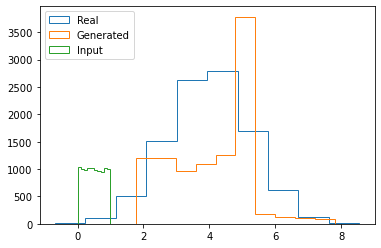

Stage 153 (Epoch: 30600)
Mean and Std of Real: (3.978007762886014, 1.2454834029903052)
Mean and Std of Gen: (4.333573, 1.1278123)


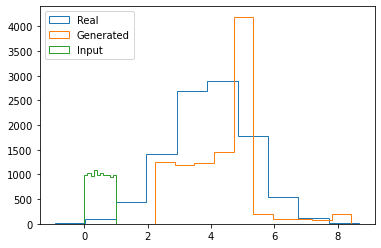

Stage 154 (Epoch: 30800)
Mean and Std of Real: (4.004369477830725, 1.2420905334985928)
Mean and Std of Gen: (3.927303, 1.3664895)


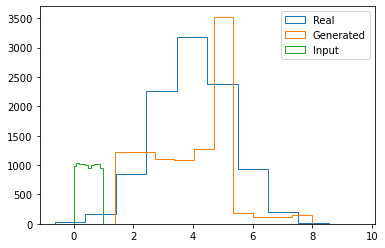

Stage 155 (Epoch: 31000)
Mean and Std of Real: (3.976796630167789, 1.2558464246508725)
Mean and Std of Gen: (3.937345, 1.288317)


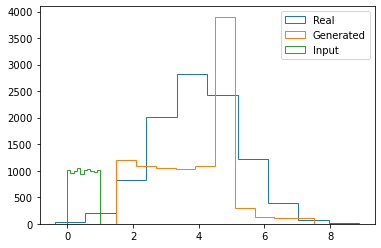

Stage 156 (Epoch: 31200)
Mean and Std of Real: (3.9895132029819504, 1.2601370995987173)
Mean and Std of Gen: (3.8328543, 1.2550888)


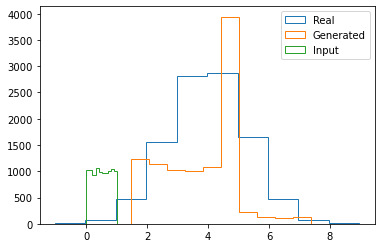

Stage 157 (Epoch: 31400)


In [ ]:
# set to use CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


# 7.2.1 패키지 임포트
from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda
from keras import models
import matplotlib.pyplot as plt
import numpy as np


# 7.2.2 데이터 관리 클래스
class Data:
    def __init__(self, mu, sigma, ni_D):
        self.real_sample = lambda n_batch: np.random.normal(mu, sigma,
                                                            (n_batch, ni_D))
        self.in_sample = lambda n_batch: np.random.rand(n_batch, ni_D)

# 7.2.3 GAN 모델링
def add_decorate(x):
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)
    return K.concatenate([x, d], axis=-1)

def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] *= 2
    return tuple(shape)

lr = 2e-4  # 0.0002
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999)
def model_compile(model):
    return model.compile(loss='binary_crossentropy', optimizer=adam,
                         metrics=['accuracy'])

class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G

        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()

    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D
        D = models.Sequential()
        D.add(Lambda(add_decorate, output_shape=add_decorate_shape,
                     input_shape=(ni_D,)))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))

        model_compile(D)
        return D

    def gen_G(self):
        ni_D = self.ni_D
        nh_G = self.nh_D

        G = models.Sequential()
        G.add(Reshape((ni_D, 1), input_shape=(ni_D,)))
        G.add(Conv1D(nh_G, 1, activation='relu'))
        G.add(Conv1D(nh_G, 1, activation='sigmoid'))
        G.add(Conv1D(1, 1))
        G.add(Flatten())

        model_compile(G)
        return G

    def make_GD(self):
        G, D = self.G, self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        model_compile(GD)
        D.trainable = True
        return GD

    def D_train_on_batch(self, Real, Gen):
        D = self.D
        X = np.concatenate([Real, Gen], axis=0)
        y = np.array([1] * Real.shape[0] + [0] * Gen.shape[0])
        D.train_on_batch(X, y)

    def GD_train_on_batch(self, Z):
        GD = self.GD
        y = np.array([1] * Z.shape[0])
        GD.train_on_batch(Z, y)

# 7.2.4 머신 구현하기
class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25

        self.n_iter_D = 1
        self.n_iter_G = 5

        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D=50, nh_G=50)

        self.n_batch = n_batch
        # self.ni_D = ni_D

    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data

        # Real data
        Real = data.real_sample(n_batch)  # (n_batch, ni_D)
        # Generated data
        Z = data.in_sample(n_batch)  # (n_batch, ni_D)
        Gen = gan.G.predict(Z)  # (n_batch, ni_D)

        gan.D.trainable = True
        gan.D_train_on_batch(Real, Gen)

    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        # Seed data for data generation
        Z = data.in_sample(n_batch)

        gan.D.trainable = False
        gan.GD_train_on_batch(Z)

    def train_each(self):
        for it in range(self.n_iter_D):
            self.train_D()
        for it in range(self.n_iter_G):
            self.train_GD()

    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each()

    def test(self, n_test):
        gan = self.gan
        data = self.data
        Z = data.in_sample(n_test)
        Gen = gan.G.predict(Z)
        return Gen, Z

    def show_hist(self, Real, Gen, Z):
        plt.hist(Real.reshape(-1), histtype='step', label='Real')
        plt.hist(Gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)

    def test_and_show(self, n_test):
        data = self.data
        Gen, Z = self.test(n_test)
        Real = data.real_sample(n_test)
        self.show_hist(Real, Gen, Z)
        Machine.print_stat(Real, Gen)

    def run_epochs(self, epochs, n_test):
        self.train(epochs)
        self.test_and_show(n_test)

    def run(self, n_repeat=200, n_show=200, n_test=100):
        for ii in range(n_repeat):
            print('Stage', ii, '(Epoch: {})'.format(ii * n_show))
            self.run_epochs(n_show, n_test)
            plt.show()

    @staticmethod
    def print_stat(Real, Gen):
        def stat(d):
            return (np.mean(d), np.std(d))
        print('Mean and Std of Real:', stat(Real))
        print('Mean and Std of Gen:', stat(Gen))

# 7.2.5 코드 수행과 결과 보기
def main():
    machine = Machine(n_batch=1, ni_D=100)
    machine.run(n_repeat=200, n_show=200, n_test=100)

main()